In [ ]:
import time
import requests
from bs4 import BeautifulSoup
import csv
import re
import nltk
import matplotlib.pyplot as plt
import random
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from collections import Counter, defaultdict

nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [64]:
sw = stopwords.words("spanish") # Lista de stopwords
ss = SnowballStemmer("spanish") # Stemmer

# Url del la primera página de los comentaris del hotel
url = "https://www.tripadvisor.com.mx/Hotel_Review-g292027-d674247-Reviews-Tranquility_Bay_Beach_Retreat-Trujillo_Colon_Department.html#REVIEWS"

def recolectar_comentarios(url, paginas=2, max_intentos=10):
  """Recolecta los comentarios(documentos) de tripadvisor y los guarda en una lista"""
  comentarios = []

  for i in range(paginas): 
    print(f"Consiguiendo los comentarios de la página {i+1}")
    headers = {
      'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36', 
      "Upgrade-Insecure-Requests": "1",
      "DNT": "1",
      "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
      "Accept-Language": "en-US,en;q=0.5",
      "Accept-Encoding": "gzip, deflate"
    }
    intentos = 0
    while intentos < max_intentos:
      try:
        r = requests.get(url, timeout=1)
        break
      except:
        intentos += 1
        if intentos < max_intentos:
          print(f"ERROR: Hubo un problema al tratar de conseguir los comentarios. Intentando de nuevo... (Intento {intentos+1}/{max_intentos})")
        time.sleep(5)
    if intentos == max_intentos:
      print("ERROR: No se pudo terminar de conseguir todos los comentarios")
      break

    soup = BeautifulSoup(r.content, "html.parser") 
    comentarios_pagina = soup.findAll("q", attrs={'class': 'IRsGHoPm'})
    comentarios_pagina = [ c.text for c in comentarios_pagina] 
    comentarios.append(comentarios_pagina)

    # Conseguir el url de la pagina siguiente
    url =  "https://www.tripadvisor.com.mx" + soup.find("a", attrs={"class": "ui_button nav next primary "})["href"]

  if i == paginas-1:
    print("Comentarios conseguidos con exito!")

  return comentarios


def procesar_comentarios(comentarios, remover_stopwords = True):
  """Procesa una lista de comentarios y retorna una lista de listas de palabras"""
  resultados = []

  for comentario in comentarios:
    comentario = comentario.lower() # Pasarlo a minuscula
    comentario = re.sub(r"[^a-z áéíóúñü]", "", comentario) # Elimina todo lo que no sea letras o espacios
    comentario = word_tokenize(comentario, "spanish") # Separa la oración en palabras
    if remover_stopwords: # Remueve las stopwords
      comentario = [palabra for palabra in comentario if palabra not in sw]
    comentario = [ss.stem(palabra) for palabra in comentario] # Hace stemming a las palabras
    resultados.append(comentario)

  return resultados

def guardar_comentarios(nombre_archivo, comentarios):
  """Guarda una lista de comentarios en un archivo .csv"""
  with open(nombre_archivo, "w") as f:
    writer = csv.writer(f)

    writer.writerow(["comentario"])
    for comentario in comentarios:
      writer.writerow(comentario)

def cargar_comentarios(nombre_archivo):
  with open(nombre_archivo, "r") as f:
    reader = csv.reader(f)
    next(reader)

    comentarios = []
    for r in reader:
      comentarios.append(r[0])

  return comentarios

def palabras_mas_probables(dist, N=10):
  palabras, probabilidad = zip(*Counter(dist).most_common(N))
  plt.figure(figsize=(15, 5))
  plt.bar(palabras, probabilidad)
  plt.xticks(fontsize=19)
  plt.yticks(fontsize=17)
  plt.show()

# Recolección y guardado de comentarios

In [ ]:
comentarios = recolectar_comentarios(url, 5)
guardar_comentarios("comentarios.csv", comentarios)

Consiguiendo los comentarios de la página 1
Consiguiendo los comentarios de la página 2
Consiguiendo los comentarios de la página 3
Consiguiendo los comentarios de la página 4
ERROR: Hubo un problema al tratar de conseguir los comentarios. Intentando de nuevo... (Intento 2/10)
ERROR: Hubo un problema al tratar de conseguir los comentarios. Intentando de nuevo... (Intento 3/10)
ERROR: Hubo un problema al tratar de conseguir los comentarios. Intentando de nuevo... (Intento 4/10)
Consiguiendo los comentarios de la página 5
Comentarios conseguidos con exito!


# Carga y procesamiento de comentarios

In [ ]:
comentarios = cargar_comentarios("comentarios.csv")
comentarios_procesados = procesar_comentarios(comentarios, remover_stopwords=False)

In [ ]:
# Cuando hay más de un documento
# c(w, d) - Lista de frecuencias de palabras por comentario frec[n][w] = frecuencia de la palabra w en el comentario n
# frec = [Counter(c) for c in comentarios_procesados]

## PLSA para solo un documento y un tema

In [ ]:
# Hacer un solo documento de todos los comentarios (usado para estimar el modelo de fondo)
corpus = [palabra for comentario in comentarios_procesados for palabra in comentario]

# Solo tomamos la mitad de los comentarios para evitar el problema que se dio con el modelo de fondo al utilizar todos los datos
N = len(comentarios_procesados) // 2
C = [palabra for comentario in comentarios_procesados[:N] for palabra in comentario]

In [ ]:
print(corpus)

['el', 'mejor', 'lug', 'par', 'qued', 'en', 'famili', 'en', 'trujill', 'no', 'te', 'preocup', 'por', 'nad', 'ya', 'que', 'tien', 'tod', 'buen', 'com', 'habit', 'comod', 'climatiz', 'y', 'la', 'play', 'muy', 'cerc', 'y', 'muy', 'segur', 'si', 'quier', 'pas', 'en', 'famili', 'es', 'el', 'lug', 'perfect', 'y', 'hay', 'much', 'cos', 'par', 'hac', 'entre', 'ellas', 'mont', 'a', 'caball', 'pase', 'en', 'lanch', 'y', 'much', 'animal', 'dentr', 'de', 'la', 'propied', 'que', 'pued', 'disfrut', 'hem', 'estad', 'realment', 'tranquil', 'disfrut', 'del', 'lug', 'y', 'de', 'tod', 'el', 'relaj', 'que', 'este', 'ambient', 'pued', 'ofrec', 'la', 'bellez', 'del', 'siti', 'se', 'complement', 'con', 'una', 'atencion', 'realment', 'especial', 'por', 'part', 'de', 'tod', 'su', 'personal', 'un', 'agradec', 'especial', 'par', 'tod', 'ellos', 'antes', 'que', 'nad', 'les', 'dig', 'que', 'los', 'dueñ', 'del', 'hotel', 'respond', 'la', 'reseñ', 'y', 'la', 'notific', 'com', 'fals', 'y', 'lueg', 'trip', 'advisor', 

In [ ]:
vocab = set(C)

In [ ]:
# Estimación del tema de fondo p(w | theta_B) con el corpus
frec = Counter(C) # Este solo aplica para el caso de un solo documento
Ptheta_B = Counter(corpus)
for palabra in Ptheta_B:
  Ptheta_B[palabra] /= len(corpus)

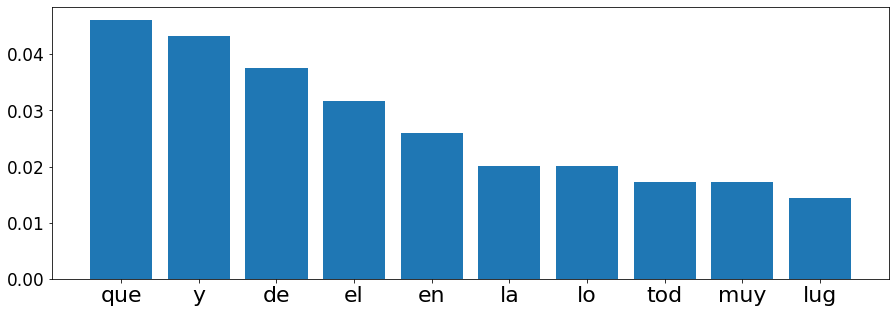

In [ ]:
# Gráfica de las 10 palabras más frecuentes
palabras_mas_probables(Ptheta_B)

In [ ]:
# P(theta_d)
theta_d = 0.1
# P(theta_B) se debe cumplir P(theta_d) + P(theta_B) = 1
theta_B = 1.0 - theta_d
# P(z = 0 | w)
Pz_0 = defaultdict(lambda : 0.0, {palabra:0.0 for palabra in vocab})
# P(w | theta_d)
Ptheta_d = defaultdict(lambda : 0.0, {palabra:1/len(vocab) for palabra in vocab})

In [ ]:
print(Ptheta_d)

defaultdict(<function <lambda> at 0x7f6bae242830>, {'famili': 0.0136986301369863, 'habit': 0.0136986301369863, 'mejor': 0.0136986301369863, 'ya': 0.0136986301369863, 'par': 0.0136986301369863, 'es': 0.0136986301369863, 'mont': 0.0136986301369863, 'perfect': 0.0136986301369863, 'caball': 0.0136986301369863, 'disfrut': 0.0136986301369863, 'hem': 0.0136986301369863, 'ellos': 0.0136986301369863, 'que': 0.0136986301369863, 'segur': 0.0136986301369863, 'de': 0.0136986301369863, 'un': 0.0136986301369863, 'del': 0.0136986301369863, 'complement': 0.0136986301369863, 'por': 0.0136986301369863, 'muy': 0.0136986301369863, 'ellas': 0.0136986301369863, 'trujill': 0.0136986301369863, 'cerc': 0.0136986301369863, 'tranquil': 0.0136986301369863, 'su': 0.0136986301369863, 'y': 0.0136986301369863, 'hay': 0.0136986301369863, 'entre': 0.0136986301369863, 'el': 0.0136986301369863, 'agradec': 0.0136986301369863, 'no': 0.0136986301369863, 'bellez': 0.0136986301369863, 'qued': 0.0136986301369863, 'lug': 0.01369

In [ ]:
# Paso E
for i in range(20):
  for w in vocab:
    Pz_0[w] = theta_d * Ptheta_d[w] / (theta_d * Ptheta_d[w] + theta_B * Ptheta_B[w])

  # Paso M
  denominador = 0.0
  for w in vocab:
    denominador += frec[w] * Pz_0[w]

  for w in vocab:
    Ptheta_d[w] = frec[w] * Pz_0[w] / denominador

In [ ]:
print(Pz_0)

defaultdict(<function <lambda> at 0x7f6bae2423b0>, {'famili': 0.195421135925114, 'habit': 0.46505903118096437, 'mejor': 0.46505903118096437, 'ya': 0.017536193230787717, 'par': 0.10494668426798064, 'es': 6.55260295897422e-10, 'mont': 0.46505903118096437, 'perfect': 0.46505903118096437, 'caball': 0.017536193230787717, 'disfrut': 0.46505607764054546, 'hem': 0.46505903118096437, 'ellos': 0.017536193230787717, 'que': 6.693898708606653e-11, 'segur': 0.017536193230787717, 'de': 4.173876887058514e-09, 'un': 6.55260295897422e-10, 'del': 0.01401650313767603, 'complement': 0.46505903118096437, 'por': 0.01401650313767603, 'muy': 8.474020951278975e-06, 'ellas': 0.46505903118096437, 'trujill': 0.46505903118096437, 'cerc': 0.46505903118096437, 'tranquil': 0.017536193230787717, 'su': 0.46505903118096437, 'y': 3.8335284037495916e-06, 'hay': 0.017536193230787717, 'entre': 0.46505903118096437, 'el': 1.1498758673120424e-07, 'agradec': 0.46505903118096437, 'no': 6.55260295897422e-10, 'bellez': 0.4650590311

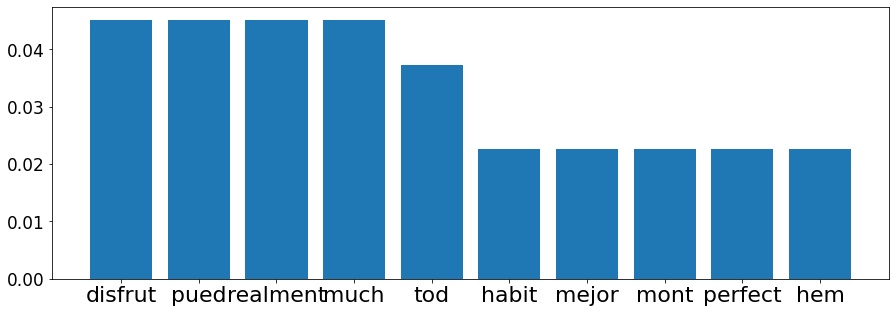

In [ ]:
# Tema utilizando modelo(tema) de fondo
palabras_mas_probables(Ptheta_d)

# PLSA sin modelo de fondo y removiendo stopwords (Unigram Model)

In [ ]:
comentarios_sin_stopwords = procesar_comentarios(comentarios) # procesamiento quitando stopwords
comentarios_sin_stopwords = [p for c in comentarios_sin_stopwords[:N] for p in c] # Hago un solo documento(comentario)
P = Counter(comentarios_sin_stopwords) # Cuento las frecuencias de cada palabra
for palabra in P:
  P[palabra] /= len(comentarios_sin_stopwords) # Divido entre el tamaño del documento

# P[w] = P(w | theta) = c(w, d) / | d |

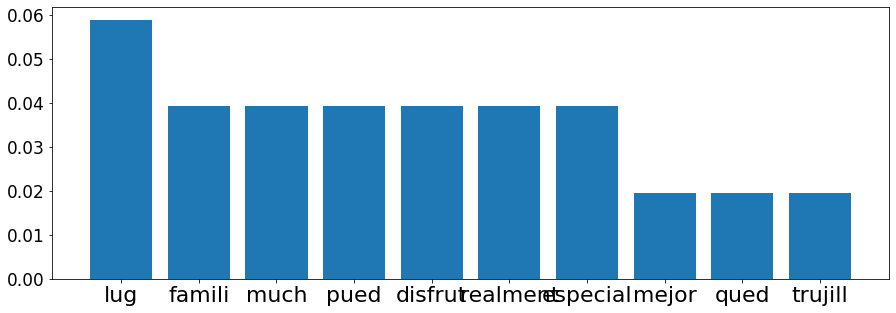

In [ ]:
# Tema sin modelo de fondo, quitando stopwords
palabras_mas_probables(P)

# PASO E Y PASO M


In [ ]:
comentarios_por_documentos=[]

for d in range(len(comentarios)):
  comentarios_por_documentos.append(comentarios[d])

documentos = procesar_comentarios(comentarios_por_documentos)

In [ ]:
documento = []
for j in range(len(documentos)):
  documento.append(set(documentos[j]))

In [ ]:
print(documento[1])

{'ambient', 'tranquil', 'siti', 'disfrut', 'agradec', 'part', 'bellez', 'ofrec', 'lug', 'complement', 'realment', 'atencion', 'especial', 'pued', 'personal', 'relaj'}


In [ ]:
Pz_j = []
# P(w : theta_j)
Ptheta_j = []
# P(Z_dw=j)
for i in range(len(documento)):
  Pz_j.append(defaultdict(lambda : 0.00, {palabra:0.00 for palabra in documento[i]}))
# P(w | theta_j)
for j in range(len(documento)):
  Ptheta_j.append(defaultdict(lambda : 0.0, {palabra:random.random() for palabra in documento[j]}))

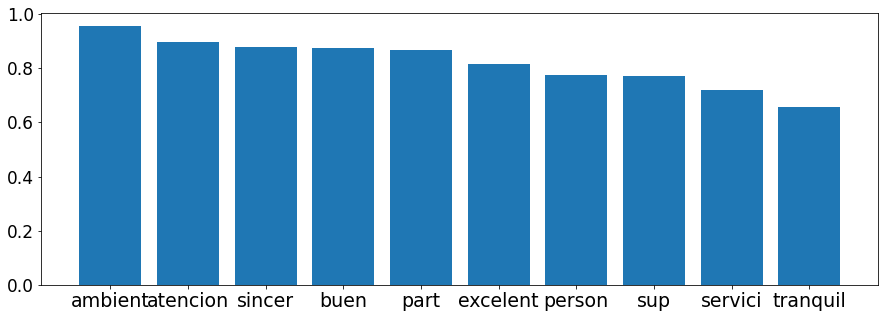

In [ ]:
theta_j = []
for i in range(len(documento)):
  theta_j.append(random.random())

In [ ]:
den = []
for i in range(len(documento)):
  for w in documento[i]:
    den.append(Ptheta_j[i][w]*theta_j[i])

denominador = sum(list(set(den)))

for i in range(len(documento)):
  for w in documento[i]:
    Pz_j[i][w] = theta_j[i]* Ptheta_j[i][w]/denominador

denominador = sum(list(set(den)))
print(Pz_j[1])

defaultdict(<function <lambda> at 0x7f6bae11f170>, {'ambient': 0.003808355685397062, 'tranquil': 0.0007774656634079775, 'siti': 0.0013476679709127862, 'disfrut': 0.0020754531422762026, 'agradec': 0.0035345585883429322, 'part': 0.0021654947117018424, 'bellez': 0.003480154880619709, 'ofrec': 0.002334026030319411, 'lug': 0.003783065489900967, 'complement': 0.002793768501366999, 'realment': 0.0005081774421609289, 'atencion': 9.816096797750147e-05, 'especial': 0.0013777140328220764, 'pued': 0.002550008833967231, 'personal': 0.0007971703545332325, 'relaj': 6.663768356596947e-05})


In [ ]:
# PASO E - 1
P_zj = []
for i in range(len(documento)):
  for w in documento[i]:
    P_zj.append(Pz_j[i][w]/denominador)

Pz = list(set(P_zj))
print(Pz)

[0.0003449522615421877, 0.00015382769350625, 0.00013359008198299597, 5.8651922268730066e-05, 0.0003102129853020976, 0.00010157925858456557, 7.233802346057151e-07, 0.00010695525212512347, 0.00011204682686916681, 2.1524171981649177e-05, 0.0008339002356596641, 9.055560590543748e-05, 4.35506347202889e-05, 0.00020331571028920823, 5.9959558367250344e-05, 0.0008382318840651918, 0.00012037774620200904, 0.00036914509308296395, 8.116955769301362e-05, 0.00014486235895107887, 9.910660814240744e-05, 0.0002525350016424886, 0.00041627705930682995, 8.410969776687255e-05, 0.0008367826271862581, 0.0002684105791770713, 9.924941923981859e-05, 0.0008298332973069461, 0.00015009747004795024, 0.0010346635734142411, 0.0001317899543343202, 0.00031623327887203014, 6.144714291661967e-05, 2.1897248247143413e-05, 0.00021995769330913122, 7.237322152693134e-05, 1.736621143695104e-05, 0.0006175635609103157, 0.00018536691277055859, 0.00012336561955301984, 0.00022600615876829132, 0.00023740285607416932, 3.46936891564998

In [ ]:
# PASO E - 2
lambda_B = 0.5
Pz_B = lambda_B * theta_B /(lambda_B * theta_B + (1-lambda_B) * denominador)

In [ ]:
# PASO M - 1
frec_m = [Counter(c) for c in comentarios_procesados]
num = []
for i in range(len(documento)):
  for w in vocab:
    num.append(frec_m[i][w]*(1-Pz_B)*Pz[i])

Pi_dj = sum(num)/(len(documento)*sum(num))

0.2


In [ ]:
# PASO M - 2
frec_m2 = [Counter(c) for c in comentarios_procesados]
num2 = []
for i in range(len(documento)):
  for w in set(frec):
    num2.append(frec_m[i][w]*(1-Pz_B)*Pz[i])
Pi_thetaj = sum(num2)/(len(vocab)*sum(num2))


0.0136986301369863

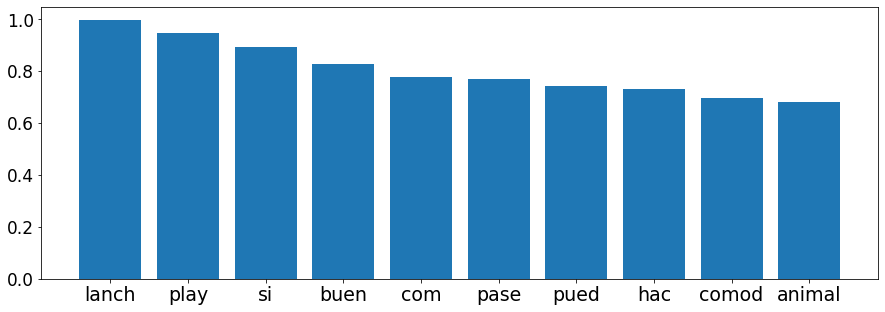

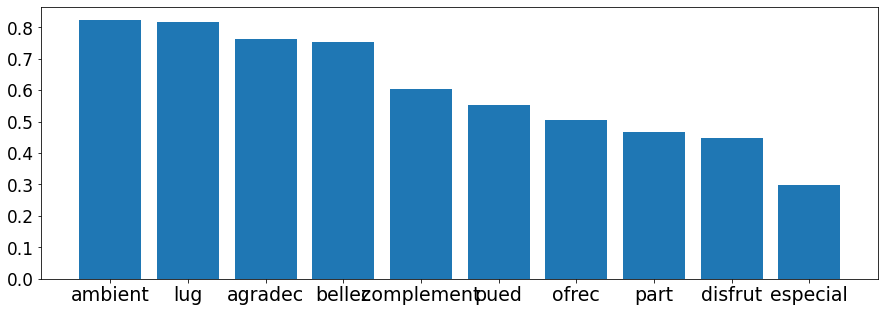

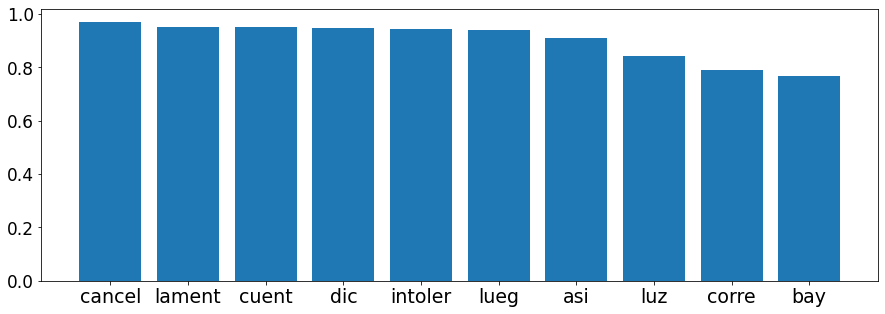

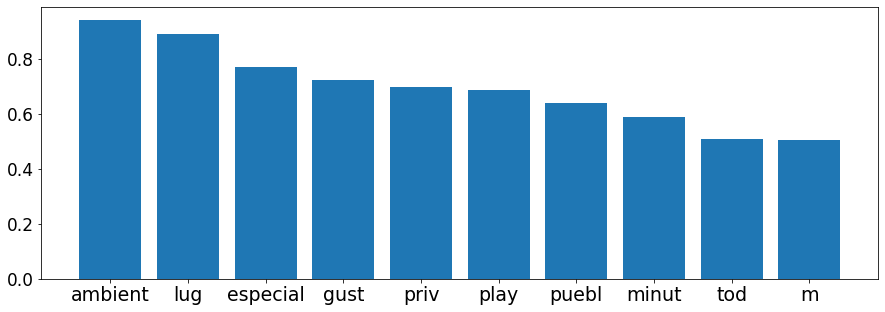

In [74]:
for i in range(4):
  palabras_mas_probables(Ptheta_j[i])